In [15]:
import numpy as np
import gudhi as gd
import networkx as nx
from scipy.spatial.distance import pdist, squareform
from bisect import bisect_left, bisect_right
import matplotlib.pyplot as plt

In [35]:
def build_filtration(num_vertices, dist_mat_e, dist_mat_f, filtration_values, use_G=False, G=nx.Graph()):
    filtration = []
    
    num_filtrations = len(filtration_values)-1
    e_filtrations = [v[0] for v in filtration_values]
    f_filtrations = [v[1] for v in filtration_values]
    
    temp_G = nx.Graph()
    
    existing_edge_matrix = np.triu(dist_mat_e <= e_filtrations[-1])
    np.fill_diagonal(existing_edge_matrix, False)
    edge_tuples = np.nonzero(existing_edge_matrix)
    for edge_idx in range(len(edge_tuples[0])):
        i, j = edge_tuples[0][edge_idx], edge_tuples[1][edge_idx]
        filtration_step_e = bisect_right(e_filtrations, dist_mat_e[i][j])-1
        if not use_G or (use_G and G.has_edge(i,j)):
            filtration.append(([i,j], filtration_step_e))
            temp_G.add_edge(i,j)
            
    face_potential_pairs = np.nonzero(np.triu(dist_mat_e <= f_filtrations[-1]))
    G_face = nx.Graph()
    G_face.add_edges_from(list(zip(face_potential_pairs[0], face_potential_pairs[1])))
    triangles = [clique for clique in nx.find_cliques(G_face) if len(clique)==3]
    for triangle in triangles:
        i,j,k = triangle[0], triangle[1], triangle[2]
        temp_G_has_triangle = temp_G.has_edge(i,j) and temp_G.has_edge(j,k) and temp_G.has_edge(i,k)
        if temp_G_has_triangle:
            face_distance = max(dist_mat_f[i][j], dist_mat_f[i][k], dist_mat_f[j][k])
            filtration_step_f = bisect_right(f_filtrations, face_distance)-1
            G_has_triangle = G.has_edge(i,j) and G.has_edge(j,k) and G.has_edge(i,k)
            if not use_G or (use_G and G_has_triangle):
                filtration.append(([i,j,k], filtration_step_f))
                
    return filtration
    

In [36]:
## Test case: randomly sampled circle with 3 points
num_pts = 100
theta = np.linspace(0,2*np.pi, num_pts)
r = np.random.rand(num_pts)
x, y = r * np.cos(theta), r * np.sin(theta)
pt_cloud = np.asarray(list(zip(x,y)))

dist_e = squareform(pdist(pt_cloud))
dist_f = squareform(pdist(pt_cloud))

filtration_values = [(0,0), (.01, .02), (.04,.03), (.05,.08), (.1,.1)]

filtration = build_filtration(num_pts, dist_e, dist_f, filtration_values)
print(filtration)

[([1, 99], 2), ([5, 7], 3), ([8, 12], 3), ([8, 19], 3), ([8, 99], 3), ([9, 11], 3), ([12, 16], 3), ([12, 19], 3), ([14, 15], 3), ([16, 19], 3), ([20, 23], 3), ([24, 25], 0), ([24, 45], 3), ([24, 54], 3), ([24, 70], 2), ([24, 95], 3), ([25, 45], 3), ([25, 54], 3), ([25, 70], 3), ([25, 95], 3), ([29, 30], 2), ([29, 32], 1), ([29, 36], 3), ([30, 32], 2), ([30, 36], 3), ([31, 34], 3), ([32, 36], 3), ([32, 38], 3), ([32, 39], 3), ([35, 37], 2), ([36, 38], 2), ([36, 39], 2), ([36, 42], 3), ([38, 39], 2), ([38, 42], 3), ([38, 45], 3), ([39, 42], 2), ([40, 41], 3), ([44, 46], 3), ([45, 54], 3), ([45, 70], 3), ([46, 47], 3), ([47, 50], 3), ([48, 49], 3), ([54, 61], 3), ([54, 66], 3), ([54, 68], 3), ([54, 70], 3), ([54, 74], 3), ([55, 56], 2), ([61, 66], 2), ([61, 68], 3), ([61, 74], 3), ([63, 64], 3), ([64, 67], 3), ([66, 68], 1), ([66, 70], 3), ([66, 73], 3), ([66, 74], 3), ([67, 72], 3), ([68, 70], 3), ([68, 73], 3), ([68, 74], 1), ([70, 74], 3), ([70, 95], 3), ([73, 74], 3), ([74, 85], 3), (

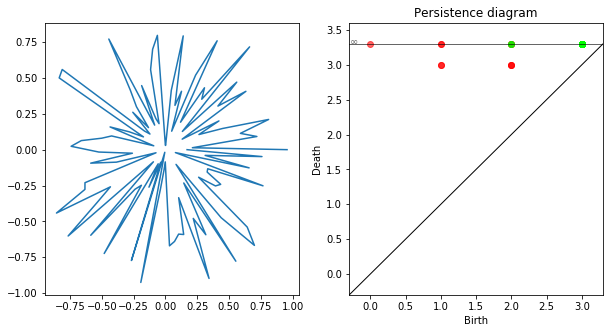

In [38]:
#Computer Persistence

sp_cpx = gd.SimplexTree()

for f in filtration:
    sp_cpx.insert(f[0],f[1])

sp_cpx.make_filtration_non_decreasing()

Barcodes = sp_cpx.persistence()

fig = plt.figure(figsize = (10,5))

fig.add_subplot(1,2,1)
plt.plot(x,y)

fig.add_subplot(1,2,2)
gd.plot_persistence_diagram(sp_cpx.persistence())
plt.show()